## BTC/USD Forecasting with LSTMs

##### Short dataset description
Dataset was sourced from : https://www.cryptodatadownload.com/data/bitfinex/. It cointains hourly historical data of the pair BTC/USD. Data are retrieved from Bitfinex (crypto cex). The columns of the data contain :

1) **open** price of the hourly candle
2) **close** price of the hourly candle
3) **low** price (min) of the hourly candle
4) **high** price (max) of the hourly candle
5) **volume** volume during the candle denominated in the respective currency (**btc/usd**)
6) **symbol** --> btc/usd
7) **unix timestamp**
8) **date**

In [141]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

#### Read the data

In [2]:
df = pd.read_csv('Bitfinex_BTCUSD_1h.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(["unix", "symbol"], axis = 1)
df = df.sort_values(by='date')

In [3]:
df.head()

,date,open,high,low,close,Volume USD,Volume BTC
44624,2018-05-15 06:00:00,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35
44623,2018-05-15 07:00:00,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97
44622,2018-05-15 08:00:00,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31
44621,2018-05-15 09:00:00,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55
44620,2018-05-15 10:00:00,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08


#### Visualization 

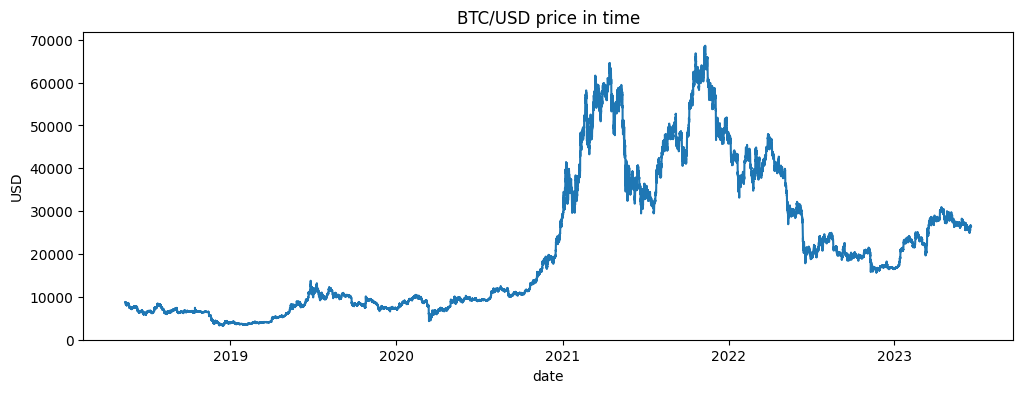

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['close'])

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')

# Displaying the plot
plt.show()

### Create Training and Test Set

#### Visualize test set

In [5]:
df_test = df.loc[(df['date'] >= '2021-11-01')].copy(deep=True)
df_train = df.loc[(df['date'] <= '2021-11-01' )].copy(deep=True)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df = df.reset_index()


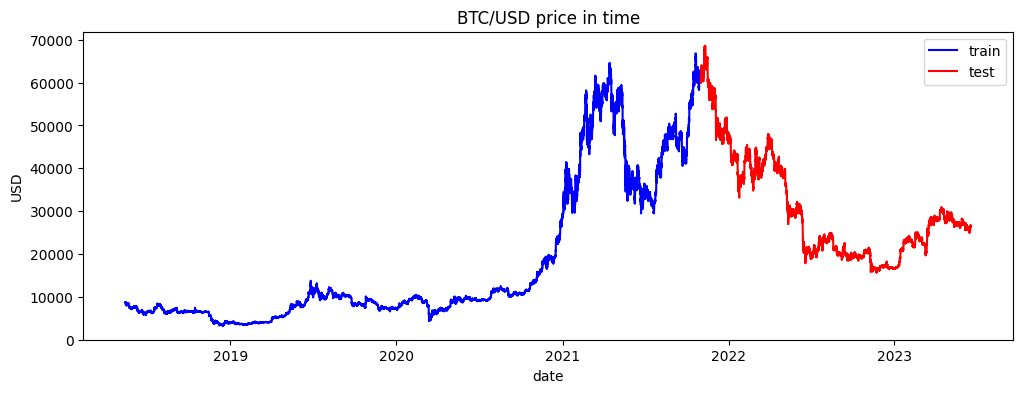

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### Create the sets

In [7]:
print("Train set consists of:", df_train.shape[0], "samples")
print("Test set consists of:", df_test.shape[0], "samples")
print("Test set is ",(df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]))*100,"of the dataset.")

Train set consists of: 30374 samples
Test set consists of: 14252 samples
Test set is  31.93653923721597 of the dataset.


## Task 1 -- Trend Prediction
For this task we consider the trend to be an uptrend (y = 1) if close[t] < open[t+1] and downtrend (y = 0) if close[t] >= open[t+1].

In [86]:
def generate_trend_prediction_set(dataset):

    data = dataset.copy(deep=True)
    l = data.shape[0]
    data['price'] = [None]*l

    for index,row in data.iterrows():
        if index+1 >= l:
            continue
        data.at[index,'price'] = data.loc[index+1]['close']

    y = data['price'].values
    data = data.drop(['price','index','date'], axis = 1)

    x = data.values[:-1]
    y = y[:-1]

    print("X has nones:",np.any(np.isnan(x)))
    print("y has nones:", np.any(np.isnan(x)))

    return x,y

In [87]:
x_train, y_train = generate_trend_prediction_set(df_train)

X has nones: False
y has nones: False


In [88]:
x_test, y_test = generate_trend_prediction_set(df_test)

X has nones: False
y has nones: False


### Normalization

In [89]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Hist Gradient Boosting Classifier

In [90]:
model = HistGradientBoostingRegressor()

In [91]:
model.fit(x_train,y_train)

HistGradientBoostingRegressor()

In [92]:
y_pred = model.predict(x_test)

In [93]:
r2_score(y_test,y_pred)

0.9953571479842942

In [97]:
math.sqrt(mean_squared_error(y_test,y_pred))

818.5161703980641

In [98]:
mean_absolute_error(y_test,y_pred)

540.600423387942

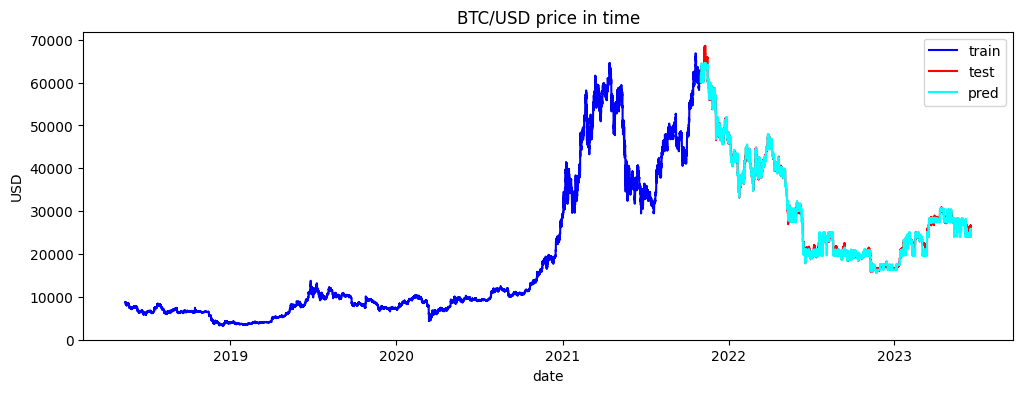

In [101]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')
plt.plot(df_test['date'][:-1], y_pred, color = 'cyan', label = 'pred')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### DNN

In [114]:
y_train_dnn = tf.convert_to_tensor(y_train, dtype=tf.float64)

In [169]:
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_shape = (x_train.shape[1],)))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

In [170]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True)
model.compile(optimizer='Adam',loss='mean_squared_error')

In [171]:
model.fit(x_train, y_train_dnn, epochs=150, batch_size=256, validation_split=0.2, callbacks=[early_stopping, checkpoint])

Epoch 1/150


95/95 [==============================] - 0s 2ms/step - loss: 157852672.0000 - val_loss: 2302897920.0000
Epoch 2/150
95/95 [==============================] - 0s 1ms/step - loss: 150283616.0000 - val_loss: 2061114880.0000
Epoch 3/150
95/95 [==============================] - 0s 1ms/step - loss: 124254496.0000 - val_loss: 1461175936.0000
Epoch 4/150
95/95 [==============================] - 0s 1ms/step - loss: 86380000.0000 - val_loss: 751830656.0000
Epoch 5/150
95/95 [==============================] - 0s 1ms/step - loss: 50933192.0000 - val_loss: 272081728.0000
Epoch 6/150
95/95 [==============================] - 0s 1ms/step - loss: 24754704.0000 - val_loss: 65150324.0000
Epoch 7/150
95/95 [==============================] - 0s 1ms/step - loss: 10968195.0000 - val_loss: 23609792.0000
Epoch 8/150
95/95 [==============================] - 0s 1ms/step - loss: 5403203.5000 - val_loss: 18081198.0000
Epoch 9/150
95/95 [==============================] - 0s 1ms/step - loss: 3178490.0000 - val_loss: 

In [172]:
model.load_weights('best_weights.h5')

In [173]:
y_pred = model.predict(x_test)

In [174]:
y_pred

array([[61554.64 ],
       [61632.152],
       [60978.67 ],
       ...,
       [26607.275],
       [26598.87 ],
       [26527.936]], dtype=float32)

In [175]:
y_pred_vals = list()
for y in y_pred:
    y_pred_vals.append(y[0])

In [176]:
math.sqrt(mean_squared_error(y_test,y_pred_vals))

238.98257133895365

In [177]:
mean_absolute_error(y_test, y_pred_vals)

140.4193256759433

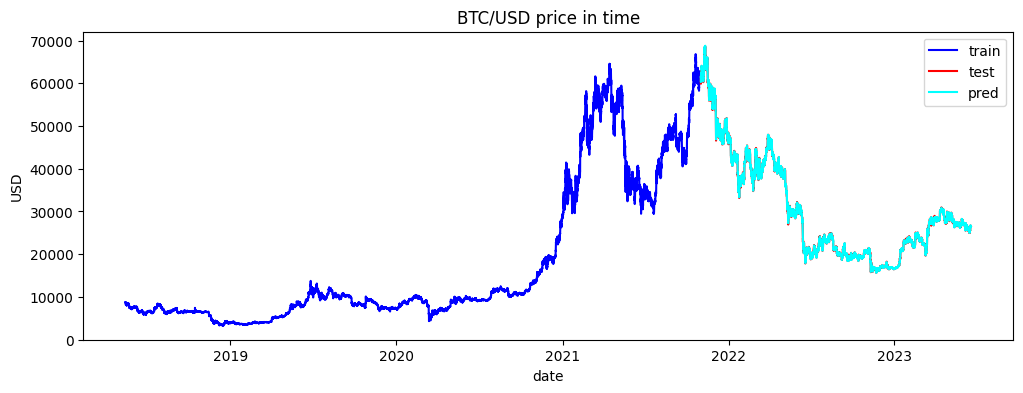

In [178]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')
plt.plot(df_test['date'][:-1], y_pred_vals, color = 'cyan', label = 'pred')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### LSTM 

In [185]:
def create_lstm_dataset(x,y):
    train_seqs = list()
    train_targets = list()

    i = 0 

    for i in range(len(x) - 24):
        seq = x[i:i+24]
        target = y[i:i+24]
        if seq.shape[0] != 24 or target.shape[0] != 24:
            continue
        train_seqs.append(seq)
        train_targets.append(target)


    train_seqs = np.array(train_seqs)
    train_targets = np.array(train_targets)

    return train_seqs,tf.convert_to_tensor(train_targets, dtype=tf.float64)


In [186]:
x_train_lstm, y_train_lstm = create_lstm_dataset(x_train,y_train)

In [187]:
x_test_lstm, y_test_lstm = create_lstm_dataset(x_test,y_test)

In [206]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),activation="relu"))
model.add(LSTM(128,activation="relu"))
model.add(Dense(1))

In [207]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True)
model.compile(loss="mean_squared_error",optimizer="adam")

In [208]:
model.fit(x_train_lstm, y_train_lstm, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping, checkpoint])

Epoch 1/100


95/95 [==============================] - 6s 50ms/step - loss: 83082664.0000 - val_loss: 68066408.0000
Epoch 2/100
95/95 [==============================] - 5s 53ms/step - loss: 1787897.0000 - val_loss: 2898730.7500
Epoch 3/100
95/95 [==============================] - 6s 58ms/step - loss: 301361.5938 - val_loss: 4988920.0000
Epoch 4/100
95/95 [==============================] - 5s 55ms/step - loss: 209857.0156 - val_loss: 2389327.7500
Epoch 5/100
95/95 [==============================] - 5s 51ms/step - loss: 175732.7500 - val_loss: 3124871.5000
Epoch 6/100
95/95 [==============================] - 5s 54ms/step - loss: 182375.2969 - val_loss: 2348040.5000
Epoch 7/100
95/95 [==============================] - 5s 54ms/step - loss: 164627.2812 - val_loss: 2272402.0000
Epoch 8/100
95/95 [==============================] - 5s 52ms/step - loss: 156378.9531 - val_loss: 2089207.2500
Epoch 9/100
95/95 [==============================] - 5s 52ms/step - loss: 162842.9688 - val_loss: 1946738.7500
Epoch 10/

In [209]:
model.load_weights('best_weights.h5')

In [210]:
y_pred = model.predict(x_test_lstm)

In [211]:
y_pred_vals = list()
for y in y_pred:
    y_pred_vals.append(y[0])

In [196]:
len(y_pred_vals)

14227

In [212]:
math.sqrt(mean_squared_error(y_test[:14227],y_pred_vals))

255.75897999973637

In [213]:
mean_absolute_error(y_test[:14227], y_pred_vals)

174.83314083212503

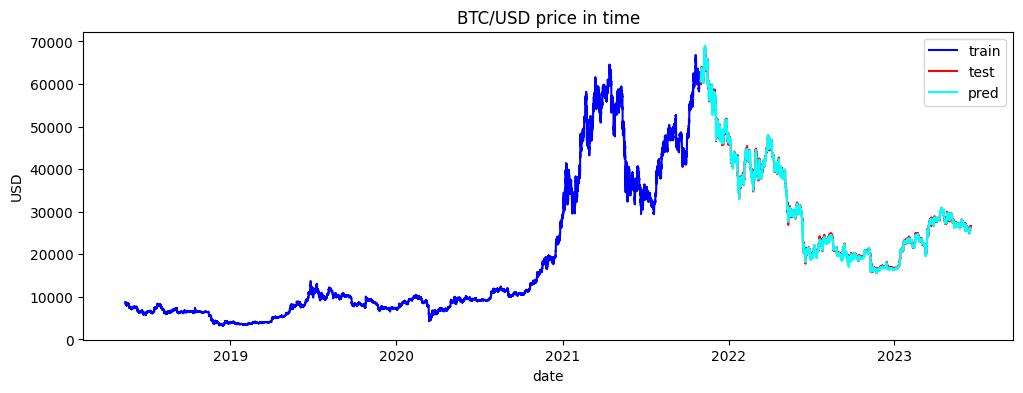

In [214]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')
plt.plot(df_test['date'][:14227], y_pred_vals, color = 'cyan', label = 'pred')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()